In [108]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib as mpl
try:
    import matplotlib.pyplot as plt
except:
    mpl.use("Agg")
    import matplotlib.pyplot as plt
    
import fitsio as fio    

from astropy.coordinates import SkyCoord
from astropy import units as u

# !jupyter nbconvert --to script TestPhotometry_deep_CatEyeballer.ipynb


# Plotter Function

In [109]:
class CatEyeballer(object):
    _cm_series = (("MAG_R", "COLOR_G_R"), ("MAG_I", "COLOR_R_I"), ("MAG_Z", "COLOR_I_Z"),
                     ("COLOR_G_R", "COLOR_R_I"), ("COLOR_R_I", "COLOR_I_Z"))

    def __init__(self, coldict, cmap=plt.cm.terrain_r):    
        self.coldict = coldict
        self.cmap = cmap     
        
    def cm_series(self, bins=None, fname=None, vmin=1e-3, vmax=None, title=None, col_prefix=""):
                
        fig, axarr = plt.subplots(nrows=2, ncols=3, figsize=(14, 8))
        faxarr = axarr.flatten()
                
        for i, ax in enumerate(faxarr):
            if i < len(self._cm_series):
                ctp = self._cm_series[i]
#                 print(ctp)
                col1 = self.coldict[col_prefix + ctp[0]]
                col2 = self.coldict[col_prefix + ctp[1]]
                
                _bins = bins[i]

                if i == 0 and vmax is None:
                    tmp = np.histogram2d(col1, col2, bins=_bins, normed=True)[0]
                    vmax = 1 * tmp.max()
                ax.hist2d(col1, col2, bins=_bins, cmap=self.cmap,
                          norm=mpl.colors.LogNorm(), normed=True, vmax=vmax, vmin=vmin)
                ax.grid(ls=":")         
                ax.set_xlabel(ctp[0])
                ax.set_ylabel(ctp[1])
                
            else:
                ax.axis("off")
                
        if title is not None:
            fig.text(0.125, 0.9, title, fontsize=16)                
                
        if fname is not None:
            fig.savefig(fname, dpi=300, bbox_inches="tight")
        return fig, axarr                
                
    def corner(self, columns=None, bins=None,
               fname=None, vmin=None, vmax=None, title=None, col_prefix=""):

        if columns is None:
            columns = list(self.coldict.keys())
        if bins is None:
            bins = []
            for col in columns:
                bins.append(np.linspace(self.coldict[col].min(),
                                        self.coldict[col].max(), nbins))

        nrows = len(columns)
        ncols = len(columns)
        xsize = 2.5 * nrows
        ysize = 2.5 * ncols

        fig, axarr = plt.subplots(nrows=nrows, ncols=nrows, figsize=(xsize, ysize))
        fig.subplots_adjust(wspace=0.1, hspace=0.1)
        faxarr = axarr.flatten()

        if title is not None:
            fig.text(0.125, 0.9, title, fontsize=16)

        # blocking upper triangle
        for i in np.arange(nrows):
            for j in np.arange(ncols):
                if j < i:
                    norm = mpl.colors.LogNorm()
                    axarr[i, j].hist2d(self.coldict[col_prefix + columns[j]],
                                       self.coldict[col_prefix + columns[i]],
                                       bins=(bins[j], bins[i]), cmap=self.cmap,
                                       norm=norm, normed=True, vmax=vmax, vmin=vmin)
                    axarr[i, j].grid(ls=":")
                if i == j:
                    axarr[i, j].hist(self.coldict[col_prefix + columns[i]], bins=bins[i],
                                     histtype="step", density=True)
                    axarr[i, j].grid(ls=":")
                if j > i:
                    axarr[i, j].axis("off")
                if i < nrows - 1:
                    axarr[i, j].set_xticklabels([])
                if j > 0:
                    axarr[i, j].set_yticklabels([])
                if j == 0 and i > 0:
                    axarr[i, j].set_ylabel(columns[i])
                if i == nrows - 1:
                    axarr[i, j].set_xlabel(columns[j])

        if fname is not None:
            fig.savefig(fname, dpi=300, bbox_inches="tight")
        return fig, axarr
        

# Loading DATA

In [110]:
# This is the run-d03-SN-C3_*_r3688p01 version
mofs = []
for i in np.arange(62):
    fname = "/e/eser2/vargatn/DES/Y3_DATA/DEEP3/run-d03-SN-C3_C{:02d}_r3688p01.fits".format(i+1)
    try:
#         print(fname)
        mofs.append(fio.read(fname))
    except:
        pass
_mofs = np.hstack(mofs)    
_ii = _mofs["flags"] == 0
mofs = _mofs[_ii]

In [111]:
# This a GOLD MOF subset overlapping with the SN-C3 field
gold = fio.read("/e/eser2/vargatn/DES/Y3_DATA/DES_Y3_GOLD_MOF_wide_SN-C3.fits")

# Match gold with MOFs

In [112]:
goldcat = SkyCoord(ra=gold["RA"]*u.degree, dec=gold["DEC"]*u.degree)  
catalog = SkyCoord(ra=mofs["ra"]*u.degree, dec=mofs["dec"]*u.degree)  
idx, d2d, d3d = catalog.match_to_catalog_sky(goldcat, nthneighbor=1) 

Text(0.5,1,'GOLD SN-C3 match')

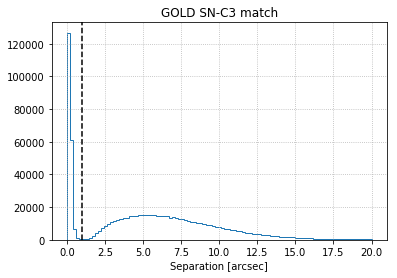

In [113]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(ls=":")

bins = np.linspace(0, 20, 100)
ax.hist(d2d.arcsec, bins=bins, histtype="step")
ax.axvline(1., color="black", ls="--")
ax.set_xlabel("Separation [arcsec]")
ax.set_title("GOLD SN-C3 match")

In [114]:
matchlim = 1.
_inds = d2d.arcsec < matchlim

In [115]:
mgold = gold[idx[_inds]]

In [116]:
mmof = mofs[_inds]

# Define what to plot

## Plotting DEEP Fields

In [117]:
mof_coldict = {
    "DEEP MAG_G": mmof["bdf_mag"][:, 0], 
    "DEEP MAG_R": mmof["bdf_mag"][:, 1],
    "DEEP MAG_I": mmof["bdf_mag"][:, 2],
    "DEEP MAG_Z": mmof["bdf_mag"][:, 3],
    "DEEP COLOR_G_R": mmof["bdf_mag"][:, 0] - mmof["bdf_mag"][:, 1],
    "DEEP COLOR_R_I": mmof["bdf_mag"][:, 1] - mmof["bdf_mag"][:, 2],
    "DEEP COLOR_I_Z": mmof["bdf_mag"][:, 2] - mmof["bdf_mag"][:, 3],
    "DEEP log10(1 + BDF_T)": np.log10(1 + mmof["bdf_T"]),
}

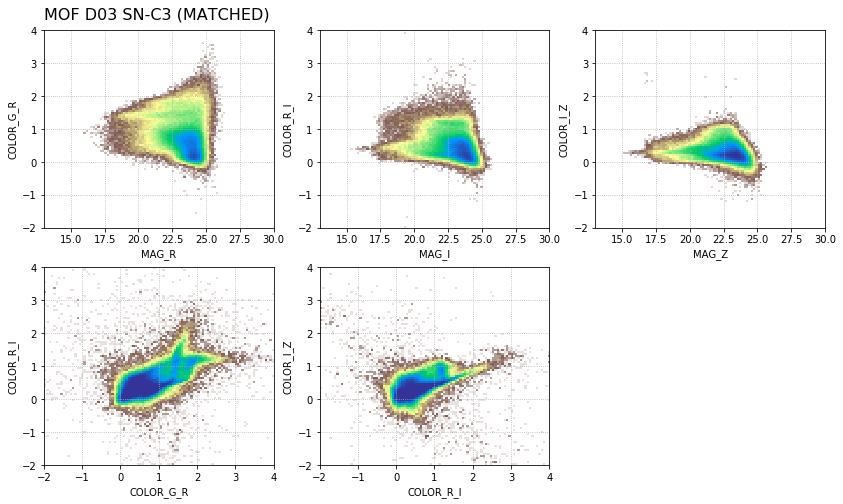

In [118]:
nbins = 100

mag_bins = np.linspace(13, 30, nbins)
color_bins = np.linspace(-2, 4, nbins)

cm_bins = (
    (mag_bins, color_bins),
    (mag_bins, color_bins),
    (mag_bins, color_bins),
    (color_bins, color_bins),
    (color_bins, color_bins),
)
cee = CatEyeballer(mof_coldict)
fig, axarr = cee.cm_series(bins=cm_bins, vmax=0.8, col_prefix="DEEP ",
                           title="MOF D03 SN-C3 (MATCHED)",
                           fname="Figs/MOF_SN-C3_color_mag_D03_match.png")

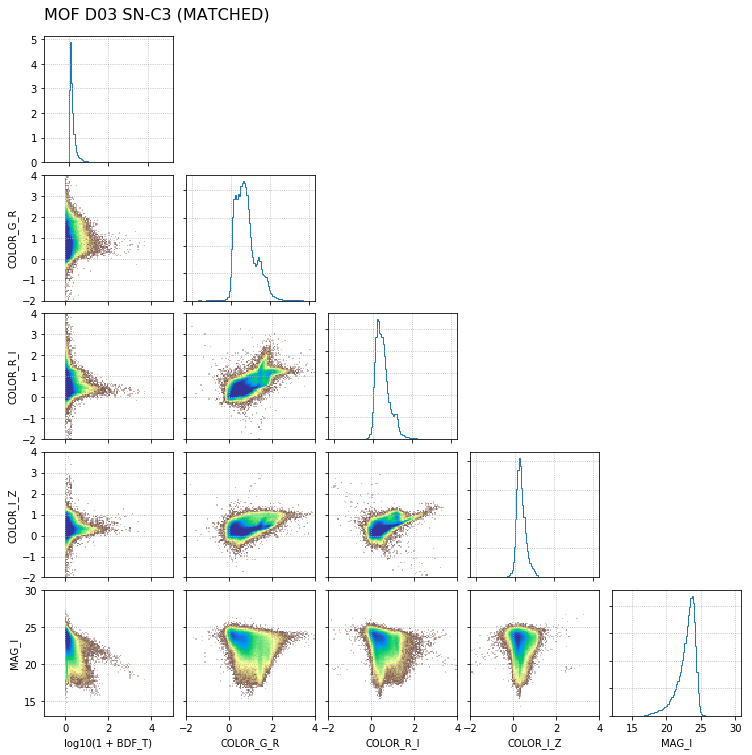

In [119]:
nbins = 100

mag_bins = np.linspace(13, 30, nbins)
color_bins = np.linspace(-2, 4, nbins)
size_bins = np.linspace(-1, 5, nbins)

columns = ("log10(1 + BDF_T)", "COLOR_G_R", "COLOR_R_I", "COLOR_I_Z", "MAG_I")
bins = (size_bins, color_bins, color_bins, color_bins, mag_bins)

cee = CatEyeballer(mof_coldict)
fig, axarr = cee.corner(columns=columns, bins=bins, vmax=0.8, col_prefix="DEEP ",
                        title="MOF D03 SN-C3 (MATCHED)",
                        fname="Figs/MOF_SN-C3_size_corner_D03_match.png")

# Plotting WIDE fields

In [123]:
gold_coldict = {
    "GOLD MAG_G": mgold["MOF_CM_MAG_G"],
    "GOLD MAG_R": mgold["MOF_CM_MAG_R"],
    "GOLD MAG_I": mgold["MOF_CM_MAG_I"],
    "GOLD MAG_Z": mgold["MOF_CM_MAG_Z"],    
    "GOLD COLOR_G_R": mgold["MOF_CM_MAG_G"] - mgold["MOF_CM_MAG_R"],
    "GOLD COLOR_R_I": mgold["MOF_CM_MAG_R"] - mgold["MOF_CM_MAG_I"],
    "GOLD COLOR_I_Z": mgold["MOF_CM_MAG_I"] - mgold["MOF_CM_MAG_Z"],
    "GOLD log10(1 + CM_T)": np.log10(1 + mgold["MOF_CM_T"]),
}

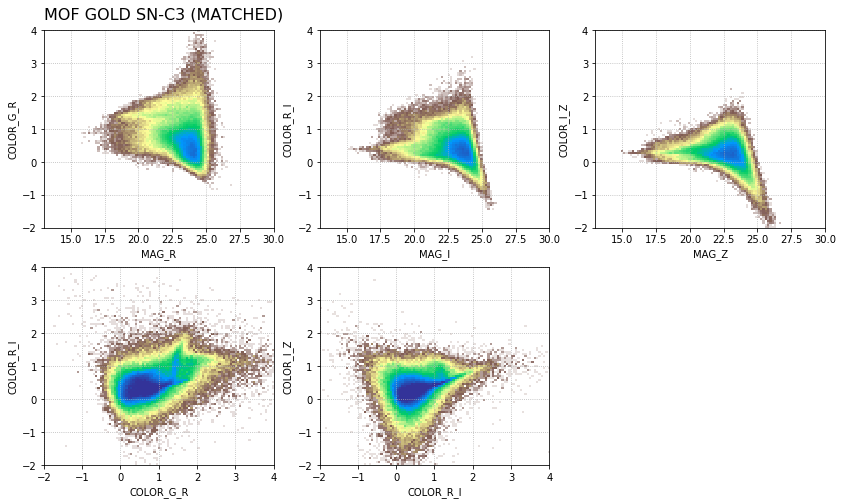

In [124]:
nbins = 100

mag_bins = np.linspace(13, 30, nbins)
color_bins = np.linspace(-2, 4, nbins)

cm_bins = (
    (mag_bins, color_bins),
    (mag_bins, color_bins),
    (mag_bins, color_bins),
    (color_bins, color_bins),
    (color_bins, color_bins),
)
cee = CatEyeballer(gold_coldict)
fig, axarr = cee.cm_series(bins=cm_bins, vmax=0.8, col_prefix="GOLD ", 
                           title="MOF GOLD SN-C3 (MATCHED)",
                           fname="Figs/MOF_SN-C3_color_mag_GOLD_match.png")

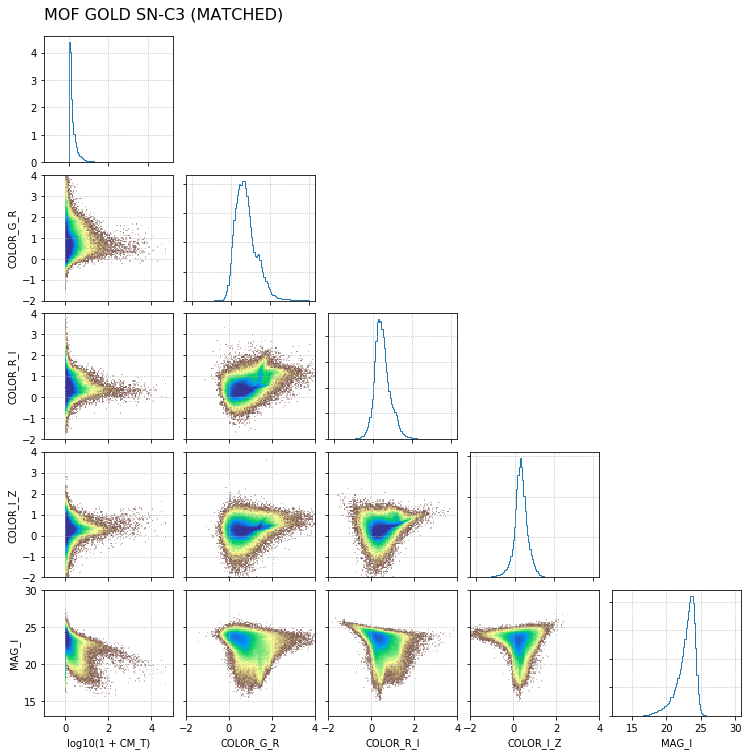

In [125]:
nbins = 100

mag_bins = np.linspace(13, 30, nbins)
color_bins = np.linspace(-2, 4, nbins)
size_bins = np.linspace(-1, 5, nbins)

columns = ("log10(1 + CM_T)", "COLOR_G_R", "COLOR_R_I", "COLOR_I_Z", "MAG_I")
bins = (size_bins, color_bins, color_bins, color_bins, mag_bins)

cee = CatEyeballer(gold_coldict)
fig, axarr = cee.corner(columns=columns, bins=bins, vmax=0.8, col_prefix="GOLD ",
                        title="MOF GOLD SN-C3 (MATCHED)",
                        fname="Figs/MOF_SN-C3_size_corner_GOLD_match.png")

# Plotting Difference between WIDE and DEEP

In [129]:
diff_coldict = {
    "DEEP MAG_G": mmof["bdf_mag"][:, 0], 
    "DEEP MAG_R": mmof["bdf_mag"][:, 1],
    "DEEP MAG_I": mmof["bdf_mag"][:, 2],
    "DEEP MAG_Z": mmof["bdf_mag"][:, 3],
    "DEEP COLOR_G_R": mmof["bdf_mag"][:, 0] - mmof["bdf_mag"][:, 1],
    "DEEP COLOR_R_I": mmof["bdf_mag"][:, 1] - mmof["bdf_mag"][:, 2],
    "DEEP COLOR_I_Z": mmof["bdf_mag"][:, 2] - mmof["bdf_mag"][:, 3],
    "DEEP log10(1 + BDF_T)": np.log10(1 + mmof["bdf_T"]),
    "GOLD MAG_G": mgold["MOF_CM_MAG_G"],
    "GOLD MAG_R": mgold["MOF_CM_MAG_R"],
    "GOLD MAG_I": mgold["MOF_CM_MAG_I"],
    "GOLD MAG_Z": mgold["MOF_CM_MAG_Z"],    
    "GOLD COLOR_G_R": mgold["MOF_CM_MAG_G"] - mgold["MOF_CM_MAG_R"],
    "GOLD COLOR_R_I": mgold["MOF_CM_MAG_R"] - mgold["MOF_CM_MAG_I"],
    "GOLD COLOR_I_Z": mgold["MOF_CM_MAG_I"] - mgold["MOF_CM_MAG_Z"],
    "GOLD log10(1 + CM_T)": np.log10(1 + mgold["MOF_CM_T"]),
    "DELTA MAG_G": mmof["bdf_mag"][:, 0] - mgold["MOF_CM_MAG_G"], 
    "DELTA MAG_R": mmof["bdf_mag"][:, 1] - mgold["MOF_CM_MAG_R"],
    "DELTA MAG_I": mmof["bdf_mag"][:, 2] - mgold["MOF_CM_MAG_I"],
    "DELTA MAG_Z": mmof["bdf_mag"][:, 3] - mgold["MOF_CM_MAG_Z"],
    "DELTA COLOR_G_R": mmof["bdf_mag"][:, 0] - mmof["bdf_mag"][:, 1] - mgold["MOF_CM_MAG_G"] + mgold["MOF_CM_MAG_R"],
    "DELTA COLOR_R_I": mmof["bdf_mag"][:, 1] - mmof["bdf_mag"][:, 2] - mgold["MOF_CM_MAG_R"] + mgold["MOF_CM_MAG_I"],
    "DELTA COLOR_I_Z": mmof["bdf_mag"][:, 2] - mmof["bdf_mag"][:, 3] - mgold["MOF_CM_MAG_I"] + mgold["MOF_CM_MAG_Z"],
    "DELTA log10(1 + T)": np.log10(1 + mmof["bdf_T"]) - np.log10(1 + mgold["MOF_CM_T"]),    
}

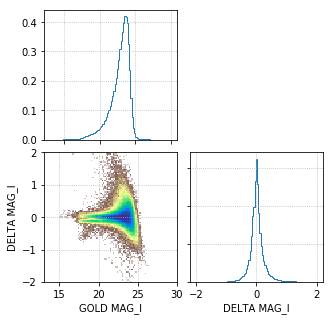

In [131]:
nbins = 100

mag_bins = np.linspace(13, 30, nbins)
color_bins = np.linspace(-2, 4, nbins)
size_bins = np.linspace(-1, 5, nbins)

delta_bins = np.linspace(-2, 2, nbins)

columns = ("GOLD MAG_I", "DELTA MAG_I")
bins = (mag_bins, delta_bins)

cee = CatEyeballer(diff_coldict)
fig, axarr = cee.corner(columns=columns, bins=bins, vmax=0.8)
#                         title="MOF GOLD SN-C3 (MATCHED)",
#                         fname="Figs/MOF_SN-C3_size_corner_GOLD_match.png")

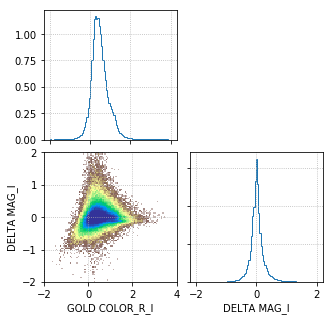

In [132]:
nbins = 100

mag_bins = np.linspace(13, 30, nbins)
color_bins = np.linspace(-2, 4, nbins)
size_bins = np.linspace(-1, 5, nbins)

delta_bins = np.linspace(-2, 2, nbins)

columns = ("GOLD COLOR_R_I", "DELTA MAG_I")
bins = (color_bins, delta_bins)

cee = CatEyeballer(diff_coldict)
fig, axarr = cee.corner(columns=columns, bins=bins, vmax=0.8)